# What you will learn from this notebook

This notebook is supposed to demonstrate a simplified version of an actual analysis you might want to run. In the real world steps would be probably the same but the dataset itself would be much, much noisier (meaning it would take some effort to put it into the required shape) and much bigger (I mean, nowadays in the industry we are dealing with more than ~30 samples!).

In [1]:
# general packages
import pandas as pd
import numpy as np

# specialized stats packages
from lifelines import KaplanMeierFitter

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# preferences
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Data

I will use one of default datasets from lifetimes library. I don't know much about it and would prefer to avoid jumping to conclusions so I will pretend this data comes actually from a survey among 26 vampires collected a 100 years ago. 

In that survey scientists collected information about how many years ago the vampire became un-dead (in other words was bitten by another vampire and turned into one), how old they were at the time of their transformation, what gender they identified with (it was a 100 years ago and backwards scientist considered it a binary variable) and whether they have experienced depression symptoms yet.

In [2]:
# data
from lifelines.datasets import load_psychiatric_patients

df = load_psychiatric_patients()

In [3]:
df.head()


,Age,T,C,sex
0,51,1,1,2
1,58,1,1,2
2,55,2,1,2
3,28,22,1,2
4,21,30,0,1


Alright, so we have vampires at different age when they tranformed (`Age` column), they reported how many years have passed since transformation (`T` column), whether they have experienced depression symptoms (`C` column) and what gender they identify with (`sex` column, I'm gonna assume `1` is binary and `2` is non-binary because why not).

# Plotting lifetimes and very basic data exploration

There aren't many variables to work with and I will first show you how to plot lifetimes (assuming *now* is at 25, change `current_time` to see how the plot changes):

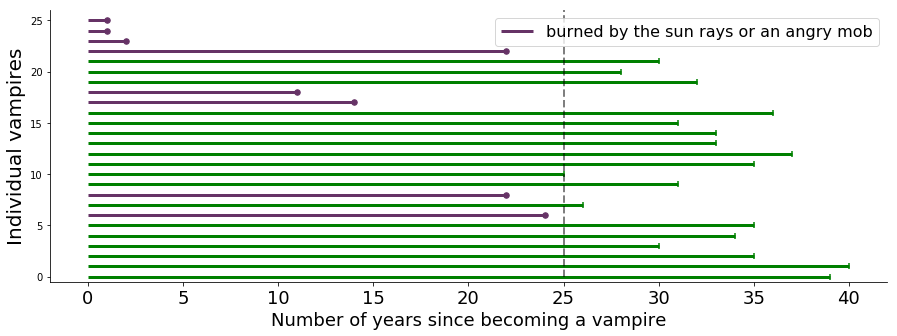

In [8]:
current_time = 25
observed_lifetimes = df['T'].values
observed = observed_lifetimes < current_time

# I'm using slightly modified function from lifetimes library. See the end of this notebook for details.
# If you are running this notebook yourself first execute the cell with function definition at the bottom
# of this notebook
plot_lifetimes(observed_lifetimes, event_observed=observed, block=True)

Next I will see whether experiencing depression symptoms is somehow related to age at which the transformation into a vampire took place:

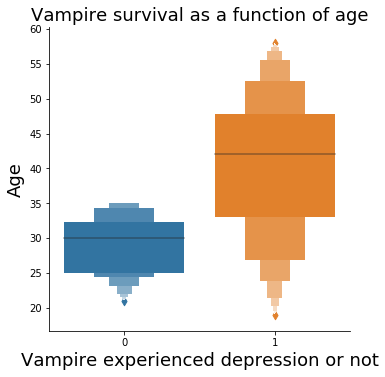

In [9]:
sns.catplot(x="C", y="Age", kind="boxen",
            data=df.sort_values("C"));
plt.xlabel('Vampire experienced depression or not', size=18)
plt.ylabel('Age', size=18)
plt.title('Vampire survival as a function of age', size=18);


Looks like it does! Appears that vampires who have experienced depressive symptoms were on average older when they were bitten and consequently turned into vampires. This is very interesting! Let's look at Kaplan-Meier curves, and hazard curves to check whether gender has anything to do with depressive symptoms.

# Kaplan-Meier curve

In [10]:
kmf = KaplanMeierFitter()
T = df["T"] # time since vampire transformation
C = df["C"] # whether they experienced depression symptoms

In [11]:
kmf.fit(T,C);

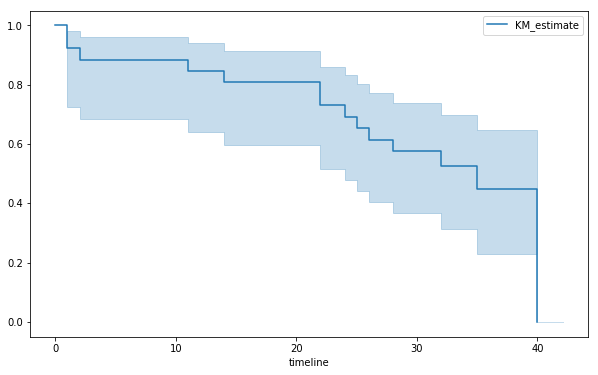

In [12]:
kmf.survival_function_
kmf.median_
kmf.plot(figsize=[10,6])

## Kaplan-Meier curve plotted separately for vampires who define themselves as binary and non-binary

<Figure size 720x432 with 0 Axes>

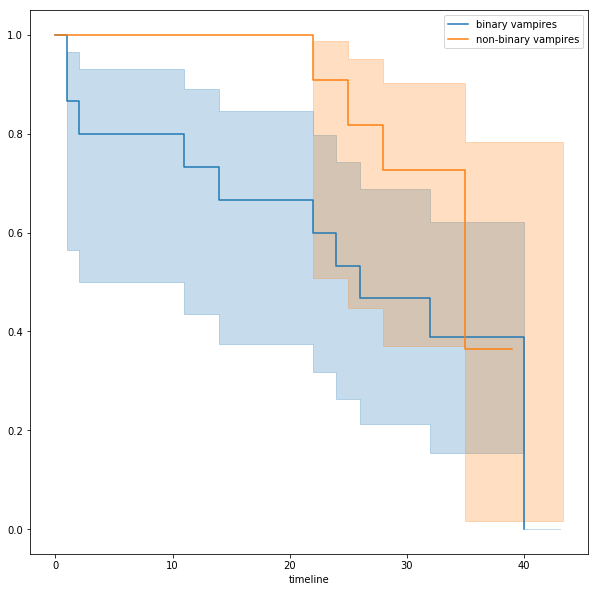

In [13]:
# plot both genders on the same plot
plt.figure(figsize=[10,6])

groups = df['sex']
ix = (groups == 1)

kmf.fit(T[~ix], C[~ix], label='binary vampires')
ax = kmf.plot(figsize=[10,10]);

kmf.fit(T[ix], C[ix], label='non-binary vampires')
kmf.plot(ax=ax);

Our sample size is small so error bars are relatively large. It looks like in the early years after vampire tranformation more binary (blue line) than non-binary (orange line) vampires experienced depressive symptoms. Maybe non-binary vampires were in a honeymoon stage with vampirism? However, the error bars are pretty much overlapping starting at 20 years past transformation so likely the differences are not statistically significant. But let's look at the hazard rate first.

# Hazard rate using Nelson-Aalen estimator

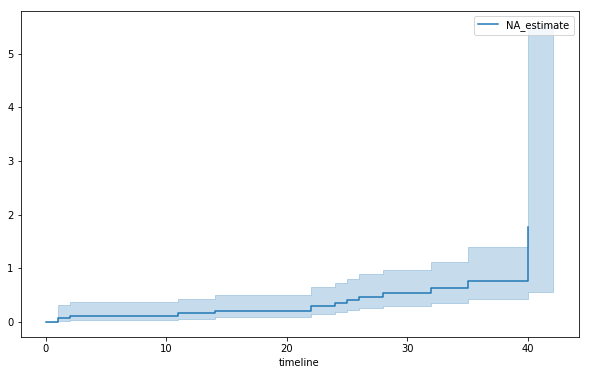

In [14]:
from lifelines import NelsonAalenFitter
naf = NelsonAalenFitter()

naf.fit(T,event_observed=C);
naf.plot(figsize=[10,6]);

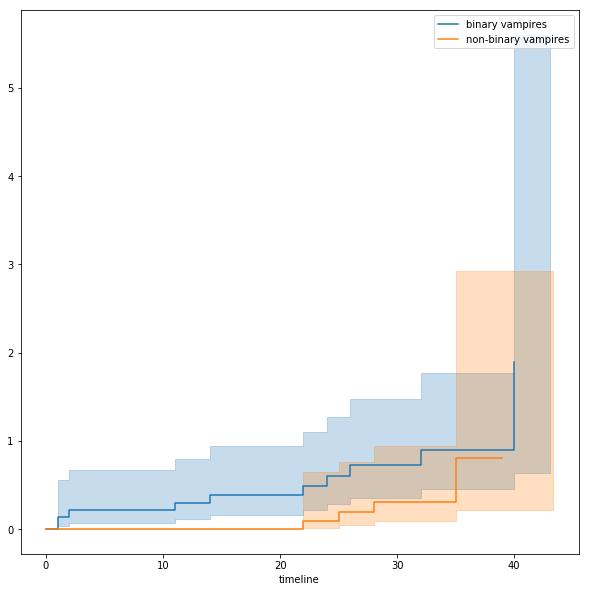

In [15]:
naf.fit(T[~ix], C[~ix], label='binary vampires')
ax = naf.plot(figsize=[10,10])

naf.fit(T[ix], C[ix], label='non-binary vampires')
naf.plot(ax=ax);

Okay, so it looks like hazard rate increases with time for both groups which we could already deduce from survival curves. Interestingly, it seems that the hazard rate for non-binary vampires increases rapidly around 35 years compared to previous period (I'm ignoring error bars for the moment).

# Statistical analysis of differences

Is there a difference between hazard rate for binary and non-binary vampires? Let's run a log rank test. It will look at random combinations of samples from the two distributions and calculate how many times one had a higher value than the other.

A very important point to remember is that this analysis will not tell us anything about the hazard rates themselves but rather whether one is different from the other - so it signals only relative differences.

In [16]:
 from lifelines.statistics import logrank_test

 results = logrank_test(T[ix], T[~ix], event_observed_A=C[ix], event_observed_B=C[~ix])
 results.print_summary()

Results
   t 0: -1
   test: logrank
   alpha: 0.95
   null distribution: chi squared
   df: 1

   __ p-value ___|__ test statistic __|____ test result ____|__ is significant __
         0.20485 |              1.607 |  Cannot Reject Null |       False       


Looks like indeed there are no significant differences between binary and non-binary vampires but for the sake of exercise let's see how to get from the test statistic to difference in hazard rate:

$$ log{\lambda} = Z \sqrt{ \frac{4}{D} }  $$

In [17]:
Z = results.test_statistic
D = C.count()

log_lambda = Z * np.sqrt (D / 4)
log_lambda

4.098143897765532

## What factors influence vampire's survival? Cox Proportional Hazards Model

Alright, and lets say now we want to look at how age and gender identity shape vampire's future. We want to train the model on one set of samples and then use it to predict relative hazard increases (it's always relative to other vampires, never absolute hazard!) during vampire's lifetime.

In [14]:
from lifelines import CoxPHFitter

cph = CoxPHFitter()
cph.fit(df, duration_col='T', event_col='C', show_progress=True)

cph.print_summary()  

Convergence completed after 5 iterations.
n=26, number of events=14

       coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95     
Age  0.2075     1.2306    0.0583  3.5606 0.0004      0.0933      0.3218  ***
sex -0.5237     0.5923    0.7375 -0.7101 0.4776     -1.9696      0.9221     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.816


It looks like age is significantly related to the occurence of depressive symptoms, just like our EDA indicated at the beginning. If we had some new data we could use the beta values calculated in by fitting method in the previous step to predict relative changes in hazard rates of new vampires (using `cph.predict_cumulative_hazard(new_df)`. This is a semi-parametric model which means that it assumes the same constant rate of change during lifetime for all vampires. There are also models which take into account time covariates but they are beyond the scope of this short notebook. Thanks for reading and good luck with your own explorations!

## Helper function

In [6]:
# the function below is a modified version of plotting function from the lifetimes library. All credit should go to
# them and all faults are mine.

def plot_lifetimes(lifetimes, event_observed=None, birthtimes=None,
                   order=False, block=True):
    """
    Parameters:
      lifetimes: an (n,) numpy array of lifetimes.
      event_observed: an (n,) numpy array of booleans: True if event observed, else False.
      birthtimes: an (n,) numpy array offsetting the births away from t=0.
    Creates a lifetime plot, see
    examples:
    """
    from matplotlib import pyplot as plt

    N = lifetimes.shape[0]
    if N > 100:
        print("warning: you may want to subsample to less than 100 individuals.")

    if event_observed is None:
        event_observed = np.ones(N, dtype=bool)

    if birthtimes is None:
        birthtimes = np.zeros(N)

    if order:
        """order by length of lifetimes; probably not very informative."""
        ix = np.argsort(lifetimes, 0)
        lifetimes = lifetimes[ix, 0]
        event_observed = event_observed[ix, 0]
        birthtimes = birthtimes[ix]
    
    fig, ax = plt.subplots(figsize=[15,5], frameon=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    for i in range(N):
        c = "#663366" if event_observed[i] else "green"
        l = 'burned by the sun rays or an angry mob' if event_observed[i] else "alive"
        
        plt.hlines(N - 1 - i, birthtimes[i], birthtimes[i] + lifetimes[i], color=c, lw=3, label=l if (i == 0) or (i==40)  else "")
        m = "|" if not event_observed[i] else 'o'
        plt.scatter((birthtimes[i]) + lifetimes[i], N - 1 - i, color=c, s=30, marker=m)
        plt.legend(fontsize=16)

    plt.xlabel("Number of years since becoming a vampire", size=18)
    plt.ylabel("Individual vampires", size=20)
    plt.vlines(current_time, 0, N, lw=2, linestyles='--', alpha=0.5)
    plt.xticks(fontsize=18)
    plt.ylim(-0.5, N)
    return